## Imports

In [1]:
# Libraries for file handling, data, and visualization
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for machine learning and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Libraries for language and transcription
import language_tool_python
import whisper
import textstat

# Libraries for RNN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


## Load CSV Data

In [3]:
# Load training and test CSVs
train_df = pd.read_csv("C:/Users/anves/Documents/desktop/shl/dataset/train.csv")
test_df = pd.read_csv("C:/Users/anves/Documents/desktop/shl/dataset/test.csv")

# Display sample data
train_df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


## Transcription and Grammar

In [4]:
# Load Whisper model for audio transcription
whisper_model = whisper.load_model("base")

# Load grammar checker
tool = language_tool_python.LanguageTool('en-US')


## Feature Extraction Function

In [5]:
# Extracts MFCCs and metadata from an audio file
def transcribe_audio(path):
    result = whisper_model.transcribe(path)
    return result['text']

def grammar_error_count(text):
    matches = tool.check(text)
    return len(matches)

def extract_features(audio_path):
    transcript = transcribe_audio(audio_path)
    num_errors = grammar_error_count(transcript)
    audio, _ = librosa.load(audio_path, sr=16000)

    # Audio features
    mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)

    # Text-based linguistic features
    num_words = len(transcript.split())
    num_sentences = transcript.count('.') + transcript.count('!') + transcript.count('?')
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else num_words
    readability = textstat.flesch_reading_ease(transcript)

    return list(mfcc_mean), [
        num_errors, num_words, num_sentences, avg_sentence_length, readability
    ]


## Extract Features for All Training Samples

In [6]:
X_seq, X_meta, y = [], [], []

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:

# # Extract features for all training samples
# for idx, row in train_df.iterrows():
#     print(f"Processing {idx}")
#     audio_path = os.path.join("C:/Users/anves/Documents/desktop/shl/dataset/audios_train", row["filename"])
#     mfcc_mean, meta_features = extract_features(audio_path)
#     X_seq.append(mfcc_mean)
#     X_meta.append(meta_features)
#     y.append(row["label"])

# X_seq = np.array(X_seq)
# X_meta = np.array(X_meta)
# y = np.array(y)

In [ ]:
# NEW CODE
import numpy as np
import os

# Initialize lists to store features and labels

# Extract features for all training samples
for idx, row in train_df.iterrows():
    print(f"Processing {idx}")
    audio_path = os.path.join("C:/Users/anves/Documents/desktop/shl/dataset/audios_train", row["filename"])
    mfcc_mean, meta_features = extract_features(audio_path)
    X_seq.append(mfcc_mean)
    X_meta.append(meta_features)
    
    # Ensure 'row["label"]' is a discrete class label for classification
    # If it's a score between 0-5, consider rounding or binning it into discrete classes
    y.append(int(row["label"]))  # Ensure it's an integer label for classification

# Convert to numpy arrays
X_seq = np.array(X_seq)
X_meta = np.array(X_meta)
y = np.array(y)

# Optionally, if y contains continuous values, you can bin it to create discrete classes
# For example, if y is a score from 0-5, you could bin it like this:
# y = np.digitize(y, bins=[0, 1, 2, 3, 4, 5])

# Now, proceed to use the features and labels for classification tasks.


Processing 0


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x000001BAC91137F0>
Traceback (most recent call last):
  File "C:\Users\anves\AppData\Local\Programs\Python\Python310\lib\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Processing 10
Processing 11
Processing 12
Processing 13
Processing 14
Processing 15
Processing 16
Processing 17
Processing 18
Processing 19
Processing 20
Processing 21
Processing 22
Processing 23
Processing 24
Processing 25
Processing 26
Processing 27
Processing 28
Processing 29
Processing 30
Processing 31
Processing 32
Processing 33
Processing 34
Processing 35
Processing 36
Processing 37
Processing 38
Processing 39
Processing 40
Processing 41
Processing 42
Processing 43
Processing 44
Processing 45
Processing 46
Processing 47
Processing 48
Processing 49
Processing 50
Processing 51
Processing 52
Processing 53
Processing 54
Processing 55
Processing 56
Processing 57
Processing 58
Processing 59
Processing 60
Processing 61
Processing 62
Processing 63
Processing 64
Processing 65
Processing 66
Processing 67
Processing 68
Processing 69
Processing 70
Processing 71
Processing 72
P

In [9]:
import numpy as np

# Save the arrays to disk
np.save('X_seq.npy', X_seq)
np.save('X_meta.npy', X_meta)
np.save('y.npy', y)


In [11]:
# Load NumPy arrays
import numpy as np
X_seq = np.load('X_seq.npy')
X_meta = np.load('X_meta.npy')
y = np.load('y.npy')


## Train-Validation Split & Scaling

In [12]:
# Split into train and validation sets
X_seq_train, X_seq_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_seq, X_meta, y, test_size=0.2, random_state=42
)

# Normalize metadata features
scaler = StandardScaler()
X_meta_train_scaled = scaler.fit_transform(X_meta_train)
X_meta_val_scaled = scaler.transform(X_meta_val)

##  Train XGBoost and SVM Models

In [13]:
# Model 1: XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(np.hstack([X_seq_train, X_meta_train_scaled]), y_train)
xgb_pred = xgb.predict(np.hstack([X_seq_val, X_meta_val_scaled]))

# Model 2: SVM
svm = SVR(kernel='rbf')
svm.fit(np.hstack([X_seq_train, X_meta_train_scaled]), y_train)
svm_pred = svm.predict(np.hstack([X_seq_val, X_meta_val_scaled]))


In [21]:
# Import necessary classifiers
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Model 1: XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(np.hstack([X_seq_train, X_meta_train_scaled]), y_train)
xgb_pred = xgb.predict(np.hstack([X_seq_val, X_meta_val_scaled]))

# Model 2: SVM Classifier
svm = SVC(kernel='rbf', random_state=42)
svm.fit(np.hstack([X_seq_train, X_meta_train_scaled]), y_train)
svm_pred = svm.predict(np.hstack([X_seq_val, X_meta_val_scaled]))

# Evaluating the models
print("XGBoost Classification Report:")
print(classification_report(y_val, xgb_pred))

print("SVM Classification Report:")
print(classification_report(y_val, svm_pred))

# Calculate accuracy
xgb_accuracy = accuracy_score(y_val, xgb_pred)
svm_accuracy = accuracy_score(y_val, svm_pred)

print(f"XGBoost Accuracy: {xgb_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7], got [1.5 2.  2.5 3.  3.5 4.  4.5 5. ]

##  Define and Train RNN

In [14]:
# PyTorch dataset class
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size=13, hidden_size=64):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :]).squeeze()

# Prepare data loaders
train_ds = MFCCDataset(X_seq_train, y_train)
val_ds = MFCCDataset(X_seq_val, y_val)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn = SimpleRNN().to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train RNN
for epoch in range(30):
    rnn.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = rnn(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


## RNN Validation and Ensemble Prediction

In [15]:
# Validate RNN
rnn.eval()
rnn_preds = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        preds = rnn(xb).cpu().numpy()
        rnn_preds.extend(preds)

# Ensemble: simple average of all three predictions
ensemble_preds2 = (xgb_pred + svm_pred + np.array(rnn_preds)) / 3

# Manually chosen weights (must sum to 1)
w_xgb = 0.5
w_svm = 0.3
w_rnn = 0.2

# Weighted ensemble
ensemble_preds = (
    w_xgb * xgb_pred +
    w_svm * svm_pred +
    w_rnn * np.array(rnn_preds)
)


## NEW CODE

Bi-LSTM on MFCCs (sequence modeling)

XGBoost & SVM on MFCC + pitch + rhythm features

Meta-model (Ridge or LightGBM) for stacking

Final ensemble via stacking

## RNN Model (Bi-LSTM on MFCC sequences)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_seq_train[0].shape[1]

model = BiLSTMClassifier(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(MFCCDataset(X_seq_train, y_train), batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(MFCCDataset(X_seq_val, y_val), batch_size=16, collate_fn=collate_fn)

for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()

model.eval()
rnn_preds = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        out = model(X_batch)
        rnn_preds.extend(torch.argmax(out, dim=1).cpu().numpy())

In [ ]:
## XGBoost & SVM

In [ ]:

svm = SVC(probability=True)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

svm.fit(X_meta_train_scaled, y_train)
xgb.fit(X_meta_train_scaled, y_train)

svm_preds = svm.predict(X_meta_val_scaled)
xgb_preds = xgb.predict(X_meta_val_scaled)

In [ ]:
## Meta Model (Stacking)

In [ ]:

stacked_input = np.vstack([rnn_preds, svm_preds, xgb_preds]).T

meta_model = RidgeClassifier()
# meta_model = LGBMClassifier()  # alternative
meta_model.fit(stacked_input, y_val)
final_preds = meta_model.predict(stacked_input)

print("Ensemble Accuracy:", accuracy_score(y_val, final_preds))

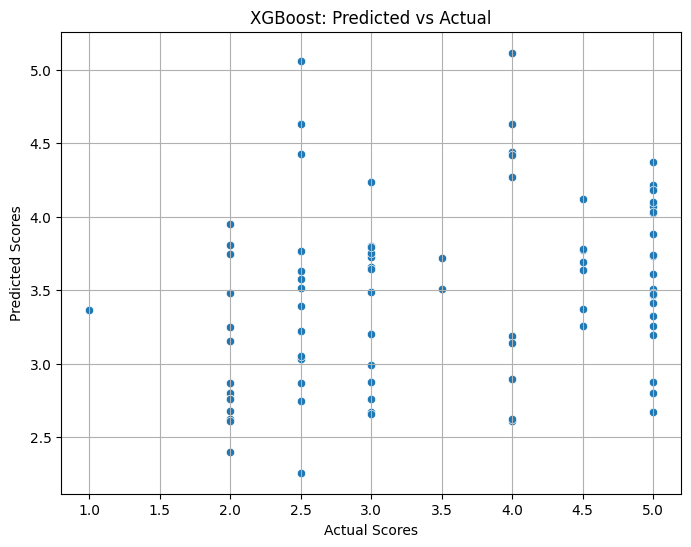

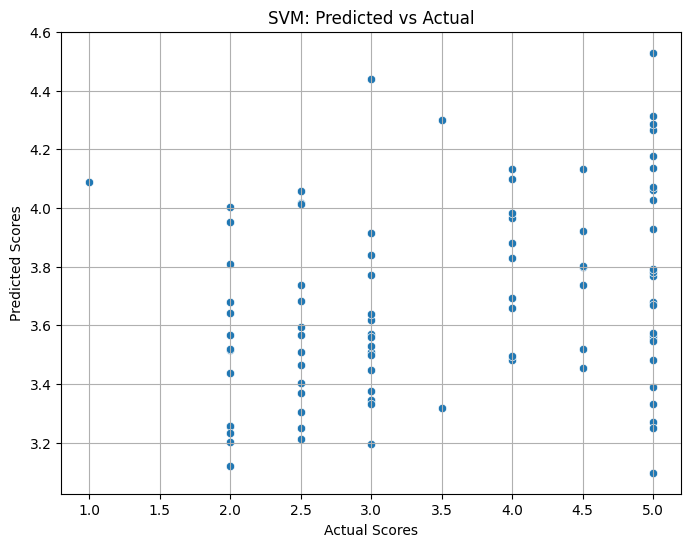

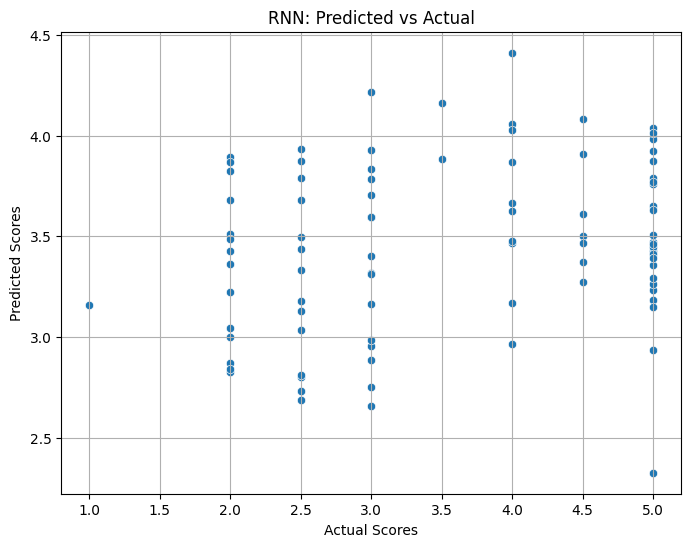

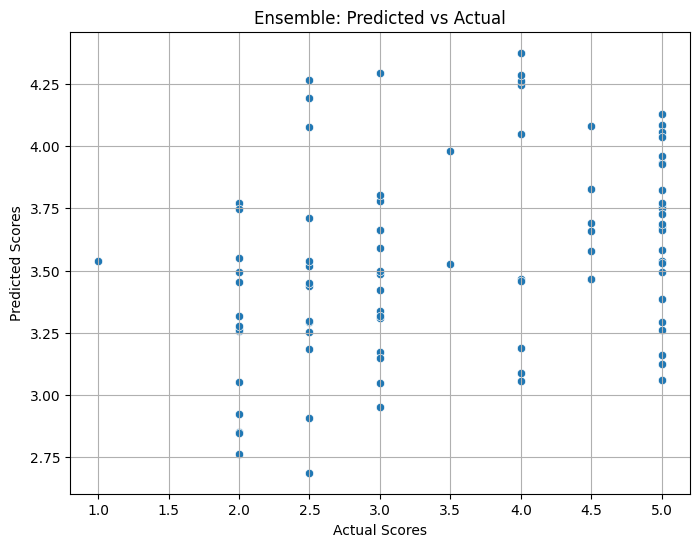

In [16]:
# --- Plot XGBoost predictions ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=xgb_pred)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("XGBoost: Predicted vs Actual")
plt.grid(True)
plt.show()

# --- Plot SVM predictions ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=svm_pred)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("SVM: Predicted vs Actual")
plt.grid(True)
plt.show()

# --- Plot RNN predictions ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=rnn_preds)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("RNN: Predicted vs Actual")
plt.grid(True)
plt.show()

# --- Plot Ensemble predictions ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=ensemble_preds)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Ensemble: Predicted vs Actual")
plt.grid(True)
plt.show()


SVM RESULTS
MSE: 1.2738992385926742
MAE: 0.9870209895418971
Pearson Correlation: 0.2819016387957422

XGBOOST RESULTS
MSE: 1.32802101964264
MAE: 1.0009521527236767
Pearson Correlation: 0.28424369064026345

RNN RESULTS
MSE: 1.328850391990786
MAE: 0.9982337737351321
Pearson Correlation: 0.22172813076550796

ENSEMBLE RESULTS
MSE: 1.206850881380623
MAE: 0.9696071698055762
Pearson Correlation: 0.3386623843830967

Classification Metrics (Rounded):
Accuracy:  0.2472
Precision: 0.0975
Recall:    0.2472
F1 Score:  0.1398


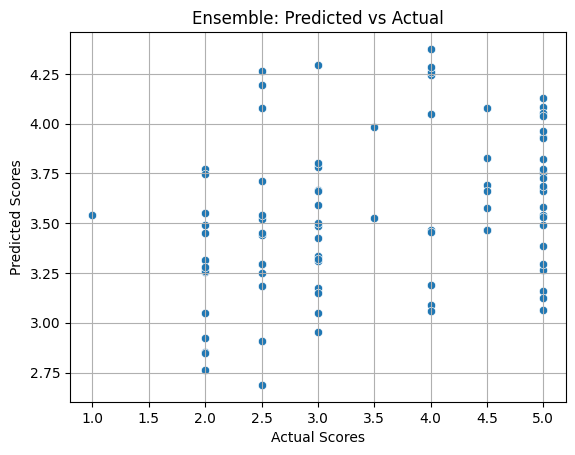

In [20]:
from scipy.stats import pearsonr


# Metrics SVM
mse = mean_squared_error(y_val, svm_pred)
mae = mean_absolute_error(y_val, svm_pred)
pearson_corr, _ = pearsonr(y_val, svm_pred)

# Display results
print("SVM RESULTS")
print("MSE:", mse)
print("MAE:", mae)
print("Pearson Correlation:", pearson_corr)

print()
# Metrics XGBOOST
mse = mean_squared_error(y_val, xgb_pred)
mae = mean_absolute_error(y_val, xgb_pred)
pearson_corr, _ = pearsonr(y_val, xgb_pred)

# Display results
print("XGBOOST RESULTS")
print("MSE:", mse)
print("MAE:", mae)
print("Pearson Correlation:", pearson_corr)

print()
# Metrics RNN
mse = mean_squared_error(y_val, rnn_preds)
mae = mean_absolute_error(y_val, rnn_preds)
pearson_corr, _ = pearsonr(y_val, rnn_preds)

# Display results
print("RNN RESULTS")
print("MSE:", mse)
print("MAE:", mae)
print("Pearson Correlation:", pearson_corr)

print()
# Metrics ENSEMBLE
mse = mean_squared_error(y_val, ensemble_preds)
mae = mean_absolute_error(y_val, ensemble_preds)
pearson_corr, _ = pearsonr(y_val, ensemble_preds)

# Display results
print("ENSEMBLE RESULTS")
print("MSE:", mse)
print("MAE:", mae)
print("Pearson Correlation:", pearson_corr)

# METRICS of ENSEMBLE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_val_class = np.round(y_val).astype(int)
ensemble_class = np.round(ensemble_preds).astype(int)

# Compute metrics
accuracy = accuracy_score(y_val_class, ensemble_class)
precision = precision_score(y_val_class, ensemble_class, average='weighted', zero_division=0)
recall = recall_score(y_val_class, ensemble_class, average='weighted', zero_division=0)
f1 = f1_score(y_val_class, ensemble_class, average='weighted', zero_division=0)

print()
print("Classification Metrics (Rounded):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


# Plot predicted vs actual
sns.scatterplot(x=y_val, y=ensemble_preds)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Ensemble: Predicted vs Actual")
plt.grid(True)
plt.show()
